# Projeto 01 - Árvore de Decisão

## Bibliotecas

In [1]:
#region Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

#
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

#
import warnings
warnings.filterwarnings('ignore')
#endregion

In [2]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    import sys

    sys.path.append("/content/drive/MyDrive/modulos")
except:
    print("Você está off-line")

Você está off-line


In [3]:
import importlib

# import modulos.estrategia1
# import modulos.estrategia3
#
# importlib.reload(modulos.estrategia1)
# importlib.reload(modulos.estrategia3)
try:
    from modulos.estrategia1 import *
    from modulos.estrategia3 import *
except:
    # Importar os módulos
    from estrategia1 import *
    from estrategia3 import *

## Carregando os Dados

In [4]:
try:
    diabetes = pd.read_csv("dataset/diabetes.csv")
except:
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    colNames = [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
        "Outcome",
    ]

    diabetes = pd.read_csv(url, names=colNames)

In [5]:
diabetesCopy = diabetes.copy()

## Análise Exploratória


### Descrição das Colunas

* Pregnancies: Número de vezes grávida
* Glucose: Concentração de glicose plasmática 2 horas após um teste oral de tolerância à glicose
* BloodPressure: Pressão arterial diastólica (mm Hg)
* SkinThickness: Espessura da prega cutânea do tríceps (mm)
* Insulin: Insulina sérica em 2 horas (mu U/ml)
* BMI: Índice de Massa Corporal (peso em kg / (altura em m)²)
* DiabetesPedigreeFunction: Função de pedigree de diabetes
* Age: Idade (anos)
* Outcome: Variável de classe (0 ou 1) – 268 dos 768 são 1, os demais são 0

In [6]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
diabetes.shape

(768, 9)

In [8]:
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Estatísticas Resumo


In [10]:
diabetes.describe().drop("Outcome", axis=1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


* **Glucose:** Média: 120,89; Máximo: 199. A média está acima do limite normal (geralmente 100 mg/dL para o jejum), o que indica uma prevalência de glicose elevada entre os participantes, possivelmente relacionada ao diabetes.

* **BloodPressure:** Média: 69,11; Máximo: 122. Este valor pode ser considerado baixo, uma vez que a pressão arterial normal é geralmente em torno de 120/80 mmHg. No entanto, a variabilidade (desvio padrão de 19,36) sugere que alguns indivíduos podem ter hipertensão

* **SkinThickness:** Média: 20,54; Máximo: 99. Um valor máximo alto pode indicar a presença de obesidade, que é um fator de risco para diabetes. O quartil inferior (0) indica que alguns dados estão ausentes ou não registrados, o que requer uma investigação mais profunda.

* **Insulin:** Média: 79,80; Máximo: 846. A variabilidade extrema (desvio padrão de 115,24) sugere que alguns participantes têm níveis de insulina muito altos, o que pode estar associado à resistência à insulina.

* **BMI:** Média: 31,99 (considerado sobrepeso/obesidade); Máximo: 67,1. Isso está alinhado com o conhecimento de que a obesidade é um fator de risco significativo para diabetes tipo 2.

* **DiabetesPedigreeFunction:** Média: 0,47; Máximo: 2,42. Esse valor mede a hereditariedade do diabetes. Valores mais altos indicam um histórico familiar mais forte, o que pode aumentar o risco de diabetes.

* **Age:** Média: 33,24 anos; Máximo: 81. A faixa etária média é relativamente jovem, embora existam indivíduos mais velhos, sugerindo que o diabetes pode afetar uma população diversificada em termos de idade.



### Distribuição dos Dados

In [11]:
# 0 -> sem diabetes
# 1 -> com diabetes
diabetes.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

In [12]:
cols = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]

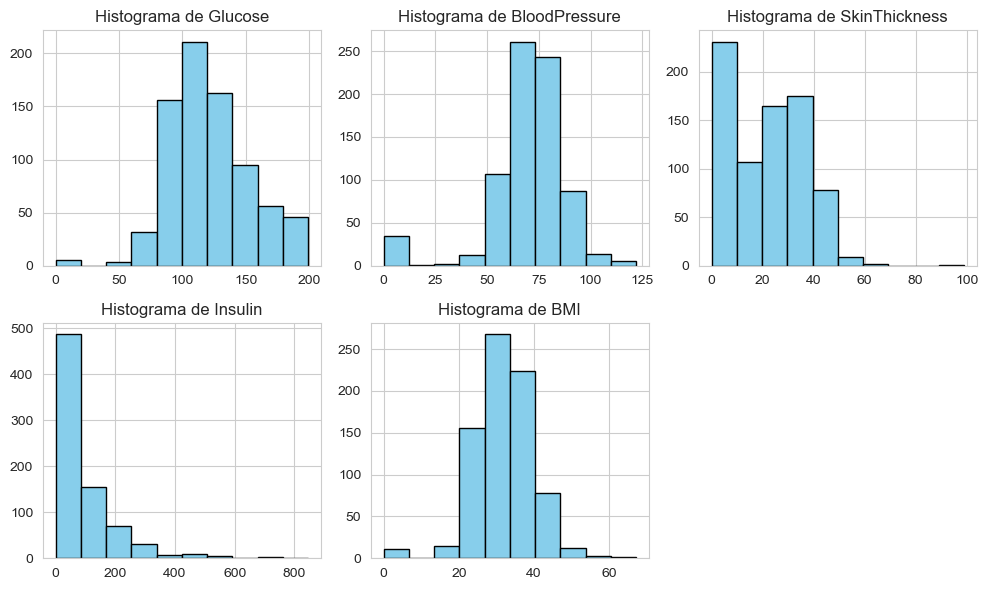

In [13]:
#region Impressão dos Histogramas dos Dados
_, axes = plt.subplots(2, 3, figsize=(10, 6))

for j, coluna in enumerate(cols):
    linha = j // 3
    colunaPos = j % 3
    axes[linha, colunaPos].hist(
        diabetes[coluna], bins=10, color="skyblue", edgecolor="black"
    )
    axes[linha, colunaPos].set_title(f"Histograma de {coluna}")

# Remove o espaço vazio do último gráfico
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()
#endregion

> **Quando usar a MÉDIA:**
* Os dados são numéricos contínuos (ex.: altura, temperatura, renda).
* Não há outliers significativos (valores extremos), pois eles distorcem a média.
* Os dados seguem uma distribuição aproximadamente normal (simétrica).

> **Quando usar a MEDIANA?**
* Há outliers presentes que poderiam distorcer a média.
* A distribuição dos dados é assimétrica, tendendo para um dos lados.
* Os dados são numéricos, mas apresentam alta variação ou dispersão

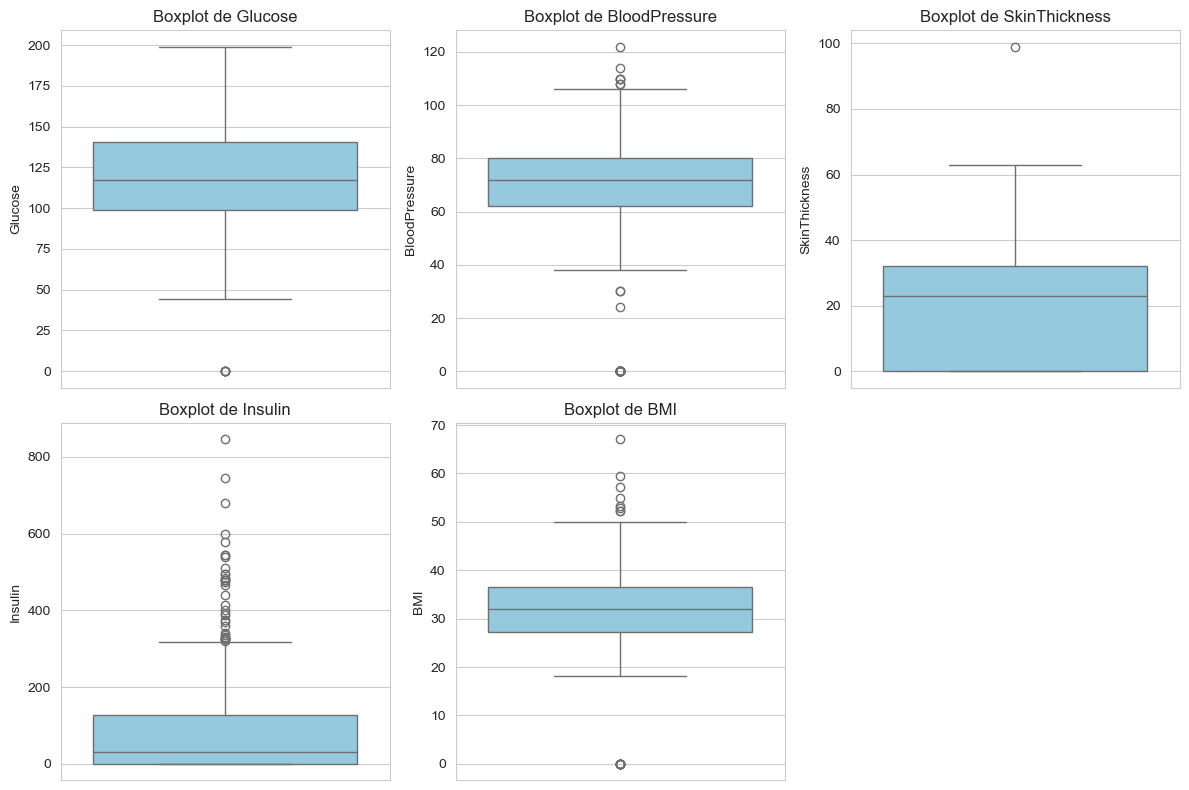

In [14]:
#region Impressão dos Boxplots dos Dados
plt.figure(figsize=(12, 8))

for i, atributo in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=diabetes[atributo], color="skyblue", orient="h")
    plt.title(f"Boxplot de {atributo}")

plt.tight_layout()
plt.show()
#endregion

### Valores Missing

In [15]:
calcPercentualValoresAusentes(diabetes)

O dataset tem 0.0 % de valores ausentes.


In [16]:
diabetes.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [17]:
# Verificando quais colunas tem valores igual a 0 (zero)
colsZero = (diabetes[cols] == 0).any()

In [18]:
colsZero

Glucose          True
BloodPressure    True
SkinThickness    True
Insulin          True
BMI              True
dtype: bool

In [19]:
zeroCounts = (diabetes[cols] == 0).sum()

# Exibir o resultado organizado por coluna
print("Soma de valores zero em cada coluna:")
print(zeroCounts)

Soma de valores zero em cada coluna:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


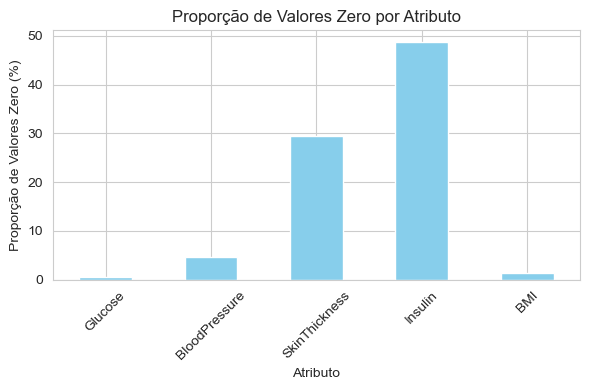

In [20]:
#region Gráfico com a % de valores ZERO por coluna
# Calcular a proporção de valores zero em cada coluna em %
zeroPercentages = round((diabetes[cols] == 0).mean() * 100, 2)

# Plotar o gráfico de barras
plt.figure(figsize=(6, 4))
zeroPercentages.plot(kind="bar", color="skyblue")

# Configurações do gráfico
plt.xlabel("Atributo")
plt.ylabel("Proporção de Valores Zero (%)")
plt.title("Proporção de Valores Zero por Atributo")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
#endregion

In [21]:
zeroPercentages

Glucose           0.65
BloodPressure     4.56
SkinThickness    29.56
Insulin          48.70
BMI               1.43
dtype: float64

#### Removendo Colunas

In [22]:
diabetes.drop(columns="Insulin", inplace=True)

### Mapa de Correlação (Spearman)

In [23]:
colsSpearman = diabetes.columns.tolist()

In [24]:
diabetes[colsSpearman].corr("spearman")

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.130734,0.185127,-0.085222,0.000132,-0.043242,0.607216,0.198689
Glucose,0.130734,1.000000,0.235191,0.060022,0.231141,0.091293,0.285045,0.475776
BloodPressure,0.185127,0.235191,1.000000,0.126486,0.292870,0.030046,0.350895,0.142921
SkinThickness,-0.085222,0.060022,0.126486,1.000000,0.443615,0.180390,-0.066795,0.089728
BMI,0.000132,0.231141,0.292870,0.443615,1.000000,0.141192,0.131186,0.309707
DiabetesPedigreeFunction,-0.043242,0.091293,0.030046,0.180390,0.141192,1.000000,0.042909,0.175353
Age,0.607216,0.285045,0.350895,-0.066795,0.131186,0.042909,1.000000,0.309040
Outcome,0.198689,0.475776,0.142921,0.089728,0.309707,0.175353,0.309040,1.000000


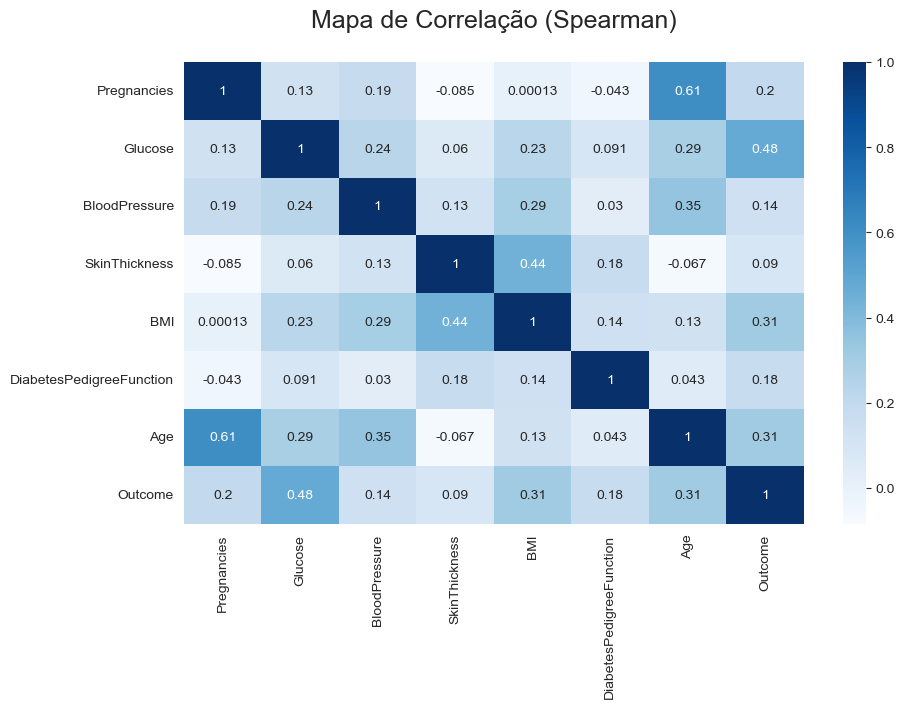

In [25]:
plt.figure(figsize=(10, 6))
sns.heatmap(diabetes[colsSpearman].corr("spearman"), annot=True, cmap="Blues")
plt.title("Mapa de Correlação (Spearman)\n", fontsize=18)
plt.show()

> Observações: O mapa de correlação acima mostra que características como **Pregnancies, Glucose, BMI e Age** estão mais intimamente associadas aos resultados.

### Análise das Colunas: Pregnancies, Glucose, BMI e Age

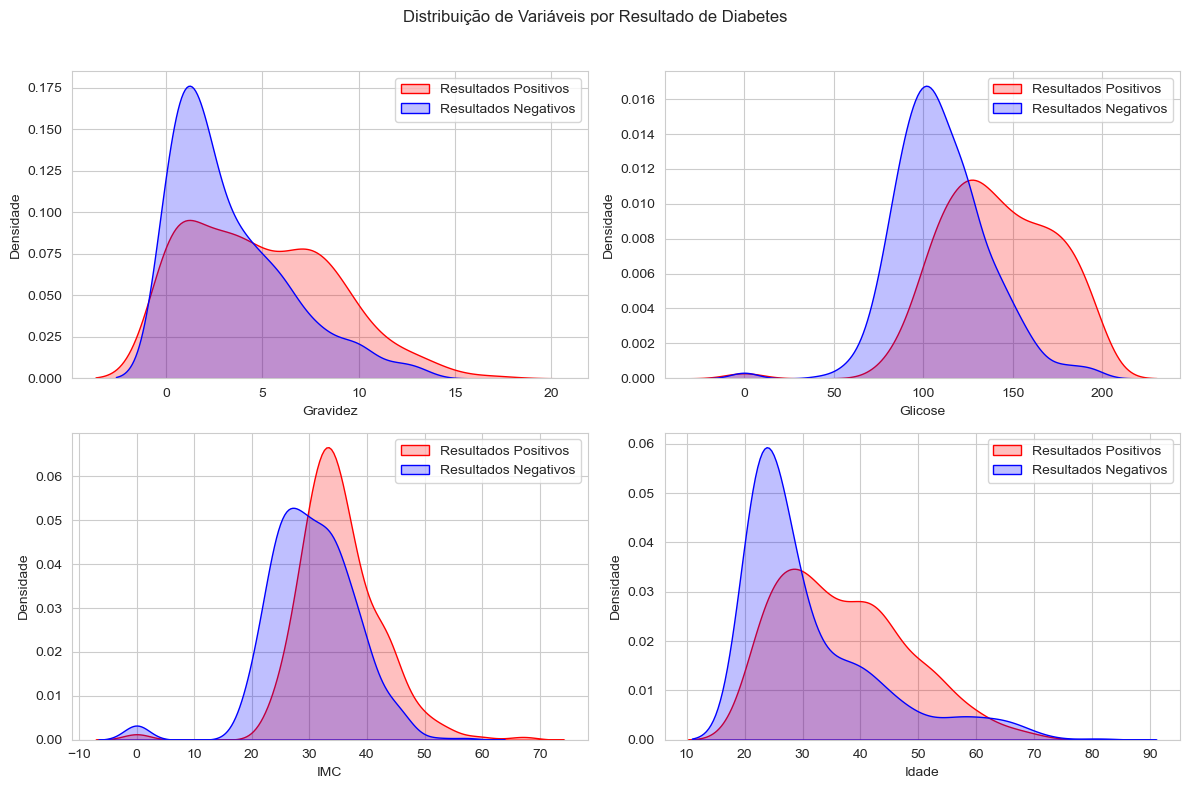

In [26]:
#region Distribuição de Variáveis por Resultado de Diabetes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Distribuição de Variáveis por Resultado de Diabetes")

variables = ["Pregnancies", "Glucose", "BMI", "Age"]
labels = ["Gravidez", "Glicose", "IMC", "Idade"]

for ax, var, label in zip(axes.flatten(), variables, labels):
    kde = sns.kdeplot(
        diabetes[var][diabetes["Outcome"] == 1], ax=ax, color="Red", fill=True
    )
    kde = sns.kdeplot(
        diabetes[var][diabetes["Outcome"] == 0], ax=ax, color="Blue", fill=True
    )
    kde.set_xlabel(label)
    kde.set_ylabel("Densidade")
    kde.legend(["Resultados Positivos", "Resultados Negativos"])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste o layout para não sobrepor o título
plt.show()
#endregion

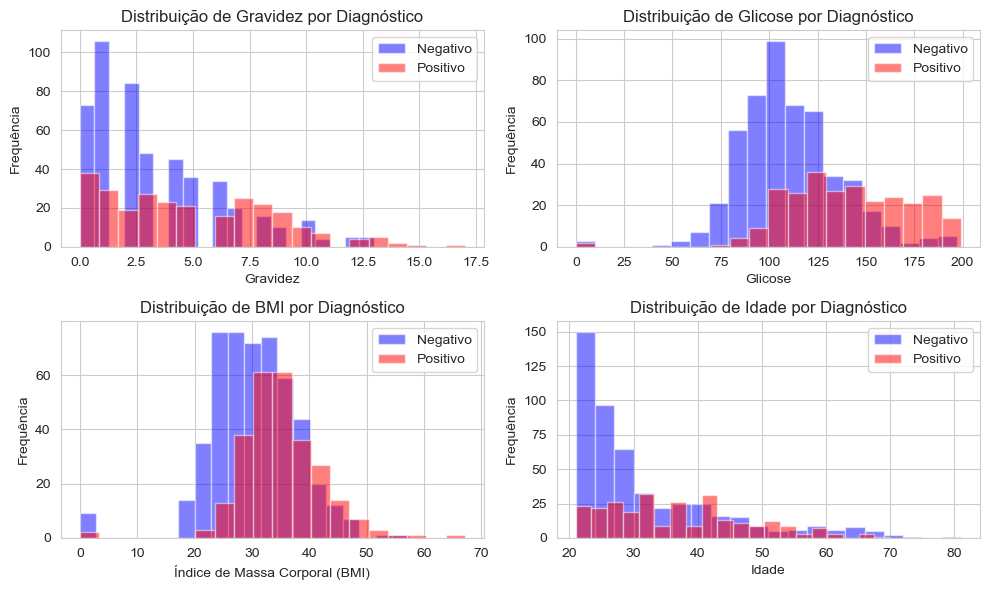

In [27]:
#region Distribuição de Variáveis por Resultado de Diabetes (Colunas)
variaveis = ["Pregnancies", "Glucose", "BMI", "Age"]
titulos = [
    "Distribuição de Gravidez por Diagnóstico",
    "Distribuição de Glicose por Diagnóstico",
    "Distribuição de BMI por Diagnóstico",
    "Distribuição de Idade por Diagnóstico",
]
xlabels = ["Gravidez", "Glicose", "Índice de Massa Corporal (BMI)", "Idade"]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

for i, var in enumerate(variaveis):
    axes[i].hist(
        diabetes[diabetes["Outcome"] == 0][var],
        bins=20,
        alpha=0.5,
        label="Negativo",
        color="blue",
    )
    axes[i].hist(
        diabetes[diabetes["Outcome"] == 1][var],
        bins=20,
        alpha=0.5,
        label="Positivo",
        color="red",
    )

    axes[i].set_xlabel(xlabels[i])
    axes[i].set_ylabel("Frequência")
    axes[i].legend(loc="upper right")
    axes[i].set_title(titulos[i])

plt.tight_layout()
plt.show()
#endregion

> **Gravidez:**
> * Através da análise acima podemos concluir que há uma maior probabilidade de mulheres com mais gravidezes apresentarem diabetes. A densidade não diminui tão rapidamente quanto no caso negativo, sugerindo que, conforme o número de gravidezes aumenta, o risco de diabetes também tende a aumentar.

> * Analisar o grafico da Idade e da Gravidez, por serem parecido pode ser que a relação mais forte seja a idade dado que na tabela de correlação o valor pra idade é maior. Possivelmente pq mulheres com muitos filhos seja tb mulheres mais velhas, como mostra a correlação de Pregnancies e Age (0.62).

> **Glicose:**
* A maior parte dos pacientes com diagnóstico negativo para diabetes apresenta níveis de glicose em torno de 100 mg/dL.
* A concentração mais significativa dos casos positivos ocorre entre 120 e 160 mg/dL, com uma parte considerável apresentando glicose superior a 160 mg/dL.
* Há uma sobreposição significativa entre as distribuições dos dois grupos na faixa entre 100 e 130 mg/dL. Essa sobreposição sugere que níveis intermediários de glicose podem **NÃO** ser suficientes para uma distinção clara entre indivíduos com e sem diabetes.

> **BMI:**
* O grupo positivo tem maior concentração de outliers em níveis mais altos de BMI, sugerindo uma maior tendência para obesidade severa entre pacientes com diagnóstico positivo.

* Esse padrão sugere que indivíduos com BMI mais alto podem estar mais propensos a desenvolver diabetes.

> **Conclusões:**
* O gráfico sugere que obesidade (refletida em um BMI elevado) pode ser um fator de risco relevante para o diabetes. No entanto, devido à sobreposição significativa entre os dois grupos, o BMI isoladamente pode não ser suficiente para diferenciar entre os indivíduos com e sem diabetes.

> **Idade:**
* A maior concentração de casos negativos (sem diabetes) está em pacientes mais jovens, entre 20 e 30 anos, ou seja, a frequência diminui significativamente à medida que a idade avança, com poucos casos negativos após os 60 anos.
* Embora também haja uma concentração na faixa entre 30 e 40 anos, a proporção de casos positivos é mais relevante nas faixas acima de 40 anos em comparação com os negativos.
* A distribuição de idade para casos positivos é mais uniforme em comparação com a distribuição dos casos negativos, que diminui rapidamente com o aumento da idade.

> **Conclusões:**
* **Idade Avançada:** Há uma tendência clara de aumento da frequência de diabetes em pacientes mais velhos, o que está de acordo com a literatura médica, que sugere que a idade é um dos fatores de risco para diabetes tipo 2.
* **Idade como Fator de Risco:** A análise sugere que o risco de diabetes aumenta com a idade, especialmente após os 40 anos.

### Outliers

In [28]:
outlier = TrataOutlier(diabetes)

In [29]:
colsOutliers = ["Glucose", "BloodPressure", "SkinThickness", "BMI"]

In [30]:
outlier.getOverview(colsOutliers)

Coluna,BloodPressure,BMI,Glucose,SkinThickness
Min,0.0,0.0,0.0,0.0
Q1,62.0,27.3,99.0,0.0
Median,72.0,32.0,117.0,23.0
Q3,80.0,36.6,140.25,32.0
Max,122.0,67.1,199.0,99.0
IQR,18.0,9.3,41.25,32.0
Lower fence,35.0,13.35,37.125,-48.0
Upper fence,107.0,50.55,202.125,80.0
Skew,-1.84,-0.43,0.17,0.11
NumOutliers,45,19,5,1


**Interpretação Skewness:**
* Valores próximos de 0: Distribuição simétrica.
* Valores positivos: Distribuição com cauda à direita (assimetria positiva).
* Valores negativos: Distribuição com cauda à esquerda (assimetria negativa).

**Magnitude:**
* Valores entre -0.5 e 0.5: Distribuição aproximadamente simétrica.
* Valores entre 0.5 e 1: Distribuição ligeiramente assimétrica.
* Valores maiores que 1: Distribuição altamente assimétrica.

## Pré-Processamento

### Substituindo os valores zeros pela Mediana

In [31]:
#region Substituindo os valores que são iguais a ZERO
# -> Mediana
diabetes["BMI"] = diabetes["BMI"].replace(0, diabetes["BMI"].median())
diabetes["Glucose"] = diabetes["Glucose"].replace(0, diabetes["Glucose"].median())
diabetes["BloodPressure"] = diabetes["BloodPressure"].replace(0, diabetes["BloodPressure"].median())
diabetes["SkinThickness"] = diabetes["SkinThickness"].replace(0, diabetes["SkinThickness"].median())
#endregion

In [32]:
(diabetes[colsOutliers] == 0).any()

Glucose          False
BloodPressure    False
SkinThickness    False
BMI              False
dtype: bool

### Tratando Outliers

In [33]:
outlier.removeOutliers(colsOutliers)
# ---
outlier.getOverview(colsOutliers)

Coluna,BloodPressure,BMI,Glucose,SkinThickness
Min,40.0,18.2,44.0,10.0
Q1,64.0,27.4,99.0,23.0
Median,72.0,32.0,117.0,23.0
Q3,78.0,35.7,139.75,32.0
Max,104.0,48.3,199.0,45.0
IQR,14.0,8.3,40.75,9.0
Lower fence,43.0,14.95,37.875,9.5
Upper fence,99.0,48.15,200.875,45.5
Skew,0.02,0.23,0.56,0.45
NumOutliers,6,1,0,0


## Normalizando os Dados

In [34]:
scaler = MinMaxScaler()

In [35]:
target = diabetes["Outcome"]
features = diabetes.drop(["Outcome"], axis=1)

In [36]:
diabetesNorm = scaler.fit_transform(features)
diabetesNorm = pd.DataFrame(diabetesNorm, columns=features.columns)
diabetesNorm["Outcome"] = target.reset_index(drop=True)

In [37]:
diabetesNorm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.173913,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.509202,0.943638,0.200000,1


## Árvore de Decisão

### Otimização dos Parâmetros

In [38]:
# ---
SEED = 10

In [39]:
# ---
colsFeatures = ["Pregnancies", "Glucose", "BMI", "Age"]

>**shuffle=True:**
* Embaralha as amostras antes de dividir os dados em treino e teste.
* O embaralhamento é útil para garantir que a divisão seja aleatória e que não haja viés devido à ordem das amostras.

> **stratify=y:**
* Garante que a proporção das classes no conjunto de treino e teste seja mantida igual à do conjunto original.
* Sem estratificação, há um risco de que uma das classes não esteja presente no conjunto de treino ou teste, especialmente em casos de dados desbalanceados.
* Se você estiver lidando com dados muito balanceados, a estratificação pode não ser necessária.

In [40]:
#region Função que Otimiza os Parâmetros para cada Estratégia
def optimizeDecisionTree(X, y, seed=SEED):
    params = {
        "max_depth": range(1, 11),
        "min_samples_split": range(2, 11),
        "min_samples_leaf": range(1, 6),
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
    }

    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y, shuffle=True)

    results = []
    for state in range(1, 101):
        tree = DecisionTreeClassifier(random_state=state)

        grid = GridSearchCV(
            estimator=tree,
            param_grid=params,
            cv=5,
            scoring="accuracy",
            n_jobs=-1,
            verbose=0,
        )

        grid.fit(train_X, train_y)
        pred_y = grid.best_estimator_.predict(test_X)
        testAccuracy = accuracy_score(test_y, pred_y)

        results.append({"state": state, "accuracy": testAccuracy, "params": grid.best_params_})

    bestResult = max(results, key=lambda x: x["accuracy"])

    print(f"\nMelhor Acurácia: {bestResult['accuracy'] * 100:.2f}%")
    print(f"Melhor Random State: {bestResult['state']}")
    print(f"Melhores Parâmetros: {bestResult['params']}")
#endregion

In [41]:
# ---
diabetesTeste = diabetesCopy

# ---------------------------------------------------------
X0 = diabetesTeste.drop("Outcome", axis=1)
y0 = diabetesTeste["Outcome"]
# --------------------------------------------------------

In [42]:
#region Testa os Modelos SEM Normalização dos Dados
# ---
diabetesTeste = diabetes

# --------------------------------------------------------
X1 = diabetesTeste.drop("Outcome", axis=1)
y1 = diabetesTeste["Outcome"]
# --------------------------------------------------------
# print("Resultado do Modelo 1")
# optimizeDecisionTree(X1, y1)

# --------------------------------------------------------
X2 = diabetesTeste[colsFeatures]
y2 = diabetesTeste["Outcome"]
# --------------------------------------------------------
# print("\nResultado do Modelo 2")
# optimizeDecisionTree(X2, y2)

# --------------------------------------------------------
X_res1 = diabetesTeste.drop("Outcome", axis=1)
y_res1 = diabetesTeste["Outcome"]
smoten = SMOTEENN(random_state=SEED)
X_resampled1, y_resampled1 = smoten.fit_resample(X_res1, y_res1)
# --------------------------------------------------------
# print("\nResultado do Modelo 3")
# optimizeDecisionTree(X_resampled1, y_resampled1)

# --------------------------------------------------------
X_res2 = diabetesTeste[colsFeatures]
y_res2 = diabetesTeste["Outcome"]
smoten = SMOTEENN(random_state=SEED)
X_resampled2, y_resampled2 = smoten.fit_resample(X_res2, y_res2)
# --------------------------------------------------------
# print("\nResultado do Modelo 4")
# optimizeDecisionTree(X_resampled2, y_resampled2)
#endregion

In [43]:
#region Testa os Modelos COM Normalização dos Dados
# ---
diabetesTeste = diabetesNorm

# --------------------------------------------------------
X3 = diabetesTeste.drop("Outcome", axis=1)
y3 = diabetesTeste["Outcome"]
# --------------------------------------------------------
# print("Resultado do Modelo 5")
# optimizeDecisionTree(X3, y3)

# --------------------------------------------------------
X4 = diabetesTeste[colsFeatures]
y4 = diabetesTeste["Outcome"]
# --------------------------------------------------------
# print("\nResultado do Modelo 6")
# optimizeDecisionTree(X4, y4)

# --------------------------------------------------------
X_res3 = diabetesTeste.drop("Outcome", axis=1)
y_res3 = diabetesTeste["Outcome"]
smoten = SMOTEENN(random_state=SEED)
X_resampled3, y_resampled3 = smoten.fit_resample(X_res3, y_res3)
# --------------------------------------------------------
# print("\nResultado do Modelo 7")
# optimizeDecisionTree(X_resampled3, y_resampled3)

# --------------------------------------------------------
X_res4 = diabetesTeste[colsFeatures]
y_res4 = diabetesTeste["Outcome"]
smoten = SMOTEENN(random_state=SEED)
X_resampled4, y_resampled4 = smoten.fit_resample(X_res4, y_res4)
# --------------------------------------------------------
# print("\nResultado do Modelo 8")
# optimizeDecisionTree(X_resampled4, y_resampled4)
#endregion

>**Mesmo que o mapa de correlação mostre que as variáveis Pregnancies, Glucose, BMI e Age estão mais intimamente associadas com o resultado de ter ou não diabetes, o fato de não haver diferença significativa na performance do modelo ao incluir todas as features pode ser explicado por vários fatores. Abaixo, detalho as possíveis razões e forneço sugestões para investigar melhor essa questão.**

>**Possíveis Motivos**
* Árvores de decisão são modelos naturalmente capazes de selecionar automaticamente as features mais importantes durante o processo de construção, ou seja, mesmo que seja mantida as *features* irrelevantes ou com baixa correlação, o modelo pode simplesmente não usá-las nas divisões da árvore, ignorando-as automaticamente.
* Em algoritmos como árvores de decisão, features irrelevantes têm menos impacto, pois o algoritmo só faz divisões onde a separação é significativa.

>**Conclusão**
* A falta de diferença no desempenho entre o uso de todas as *features* e apenas um subconjunto pode ser explicada pela capacidade da árvore de decisão de selecionar automaticamente as variáveis mais importantes e pela possível informação complementar nas outras variáveis. Como as árvores de decisão lidam bem com *features* irrelevantes, manter todas as colunas não deve prejudicar o desempenho.



## Matriz de Confusão e Relatório de Classificação

### Avaliação & Resultados

In [44]:
#region Treino & Avaliação
def trainAndEvaluate(
    X,
    y,
    params,
    state,
    showAccuracy=False,
    showClassificationReport=False,
    showConfusionMatrix=False,
    showFeatures=False,
    showTree=False
):
    # Dividir os dados em treino e teste
    train_X, test_X, train_y, test_y = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=state,
        shuffle=True,
        stratify=y,
    )

    # Treinar o modelo
    model = DecisionTreeClassifier(**params)
    model.fit(train_X, train_y)

    # Calcular a acurácia
    trainAccuracy = model.score(train_X, train_y) * 100
    testAccuracy = model.score(test_X, test_y) * 100
    predictions = model.predict(test_X)

    print(f"Acurácia do Treino: {trainAccuracy:.2f}%")
    print(f"Acurácia do Teste: {testAccuracy:.2f}%")

    # Matriz de Confusão e Relatório de Classificação
    matriz = confusion_matrix(test_y, predictions)
    report = classification_report(test_y, predictions)
    print("\nMatriz de Confusão:")
    print(matriz)

    print("\nRelatório de Classificação:")
    print(report)

    # Gráfico de Acurácia
    if showAccuracy:
        plt.figure(figsize=(8, 5))
        accuracy_values = [trainAccuracy, testAccuracy]
        labels = ["Treino", "Teste"]
        colors = ["skyblue", "lightcoral"]

        bars = plt.bar(labels, accuracy_values, color=colors)
        plt.ylim(0, 100)
        plt.ylabel("Acurácia (%)")
        plt.title("Acurácia do Modelo")

        # Adicionar os percentuais em cima das barras
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}%",  # Mostrar porcentagem
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
            )

        plt.show()

    # Plotar a Matriz de Confusão
    if showConfusionMatrix:
        plt.figure(figsize=(4, 3))
        sns.heatmap(
            matriz,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=["Classe 0", "Classe 1"],
            yticklabels=["Classe 0", "Classe 1"],
        )
        plt.xlabel("Classe Predita")
        plt.ylabel("Classe Verdadeira")
        plt.title("Matriz de Confusão")
        plt.show()

    # Plota o Relatório de Classificação
    if showClassificationReport:
        report_df = pd.DataFrame(
            classification_report(test_y, predictions, output_dict=True)
        ).transpose()
        metrics = ["precision", "recall", "f1-score"]

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for i, metric in enumerate(metrics):
            bars = axes[i].bar(
                report_df.index[:-3],
                report_df[metric][:-3],
                color=["skyblue", "lightcoral"],
            )
            axes[i].set_title(f"{metric.capitalize()} por Classe")
            axes[i].set_xlabel("Classe")
            axes[i].set_ylabel(metric.capitalize())
            axes[i].set_ylim(0, 1)

            # Adicionar os percentuais nas barras
            for bar in bars:
                height = bar.get_height()
                axes[i].text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f"{height * 100:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    color="black",
                )

        plt.tight_layout()
        plt.show()

    # Plota a Árvore
    if showTree:
        featuresNames = X.columns
        targetNames = ["0", "1"]
        plt.figure(figsize=(60, 20), dpi=100)
        tree.plot_tree(
            model, feature_names=featuresNames, class_names=targetNames, filled=True
        )
        plt.show()

    # Plota as Importâncias das Features
    if showFeatures:
        plt.figure(figsize=(6, 4))
        features = len(model.feature_importances_)
        plt.barh(
            range(features), model.feature_importances_, align="center", color="blue"
        )
        plt.yticks(np.arange(features), X.columns)
        plt.xlabel("Feature importance")
        plt.ylabel("Feature")
        plt.ylim(-1, features)
        plt.show()
#endregion

#### Modelo 0

--------------------------------------------------------
Resultados do Modelo 0 - Todas as Colunas:

Acurácia do Treino: 100.00%
Acurácia do Teste: 67.53%

Matriz de Confusão:
[[72 28]
 [22 32]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       100
           1       0.53      0.59      0.56        54

    accuracy                           0.68       154
   macro avg       0.65      0.66      0.65       154
weighted avg       0.68      0.68      0.68       154



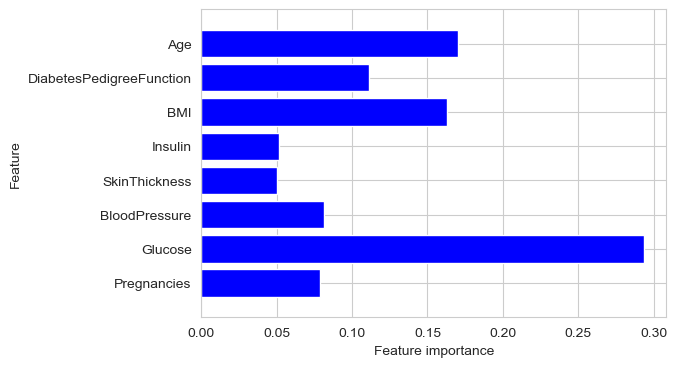

--------------------------------------------------------
None


In [45]:
#region Modelo 0
# ---
params0 = {}

print("--------------------------------------------------------")
print("Resultados do Modelo 0 - Todas as Colunas:\n")
result = trainAndEvaluate(
    X0,
    y0,
    params=params0,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("--------------------------------------------------------")
print(result)
#endregion

#### Modelo 1 - Todas as Colunas - Sem Normalização / Com Normalização

--------------------------------------------------------
Resultados do Modelo 1 - Todas as Colunas:

Acurácia do Treino: 76.22%
Acurácia do Teste: 74.68%

Matriz de Confusão:
[[90 10]
 [29 25]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82       100
           1       0.71      0.46      0.56        54

    accuracy                           0.75       154
   macro avg       0.74      0.68      0.69       154
weighted avg       0.74      0.75      0.73       154



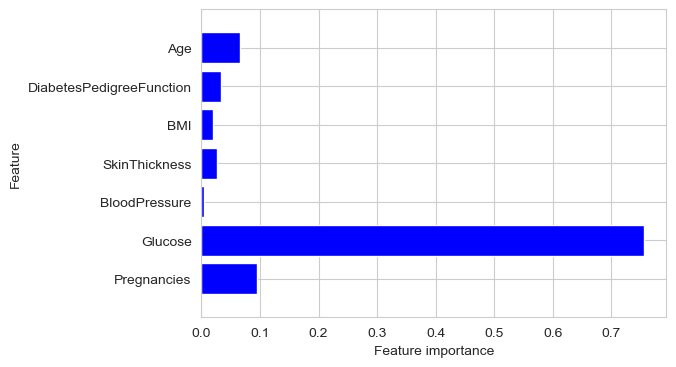

--------------------------------------------------------
Resultados do Modelo 1 - Todas as Colunas (Normalizado):

Acurácia do Treino: 87.30%
Acurácia do Teste: 76.62%

Matriz de Confusão:
[[78 22]
 [14 40]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       100
           1       0.65      0.74      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154



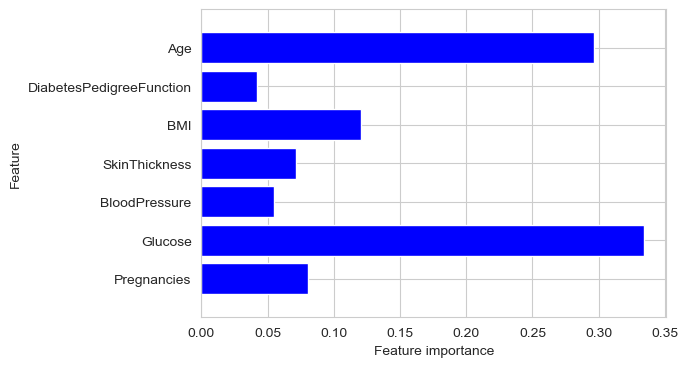

--------------------------------------------------------


In [46]:
#region Resultados do Modelo 1 - Todas as Colunas
# ---
params1 = {
    "criterion": "gini",
    "max_depth": 4,
    "min_samples_leaf": 4,
    "min_samples_split": 2,
    "splitter": "random",
    "random_state": 69,
}

# ---
params5 = {
    "criterion": "gini",
    "max_depth": 8,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "splitter": "random",
    "random_state": 48,
}

print("--------------------------------------------------------")
print("Resultados do Modelo 1 - Todas as Colunas:\n")
trainAndEvaluate(
    X1,
    y1,
    params=params1,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("--------------------------------------------------------")
print("Resultados do Modelo 1 - Todas as Colunas (Normalizado):\n")
trainAndEvaluate(
    X3,
    y3,
    params=params5,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("--------------------------------------------------------")
#endregion

#### Modelo 1 - Somente as Features - Sem normalização / Com Normalização

--------------------------------------------------------
Resultados do Modelo 1 - Features:

Acurácia do Treino: 84.20%
Acurácia do Teste: 75.32%

Matriz de Confusão:
[[79 21]
 [17 37]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.64      0.69      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.76       154



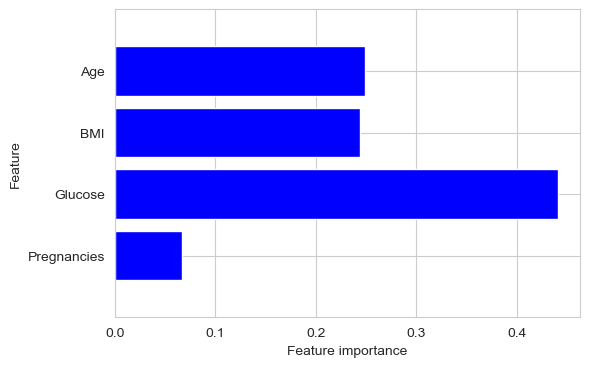

--------------------------------------------------------
Resultados do Modelo 1 - Features (Normalizado):

Acurácia do Treino: 84.20%
Acurácia do Teste: 75.32%

Matriz de Confusão:
[[79 21]
 [17 37]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.64      0.69      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.76       154



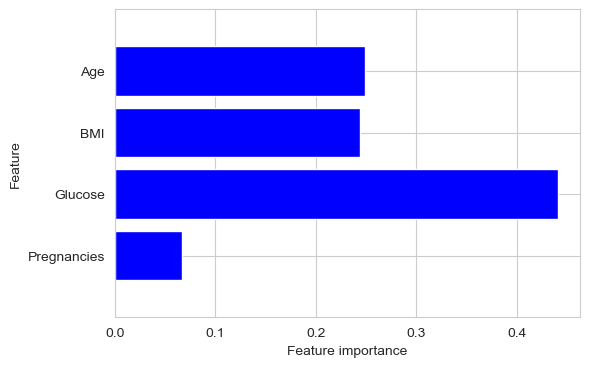

--------------------------------------------------------


In [47]:
#region Resultados do Modelo 1 - Features
# ---
params2 = {
    "criterion": "entropy",
    "max_depth": 7,
    "min_samples_leaf": 5,
    "min_samples_split": 2,
    "splitter": "best",
    "random_state": 1,
}

# ---
params6 = {
    "criterion": "entropy",
    "max_depth": 7,
    "min_samples_leaf": 5,
    "min_samples_split": 2,
    "splitter": "best",
    "random_state": 1,
}

print("--------------------------------------------------------")
print("Resultados do Modelo 1 - Features:\n")
trainAndEvaluate(
    X2,
    y2,
    params=params2,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("--------------------------------------------------------")
print("Resultados do Modelo 1 - Features (Normalizado):\n")
trainAndEvaluate(
    X4,
    y4,
    params=params6,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("--------------------------------------------------------")
#endregion

#### Modelo 2 - Todas as Colunas - Sem Normalização / Com Normalização

-------------------------------------------------------------------
Resultados do Modelo 2 - Todas as Colunas (Resample):

Acurácia do Treino: 98.64%
Acurácia do Teste: 94.55%

Matriz de Confusão:
[[47  2]
 [ 4 57]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        49
           1       0.97      0.93      0.95        61

    accuracy                           0.95       110
   macro avg       0.94      0.95      0.94       110
weighted avg       0.95      0.95      0.95       110



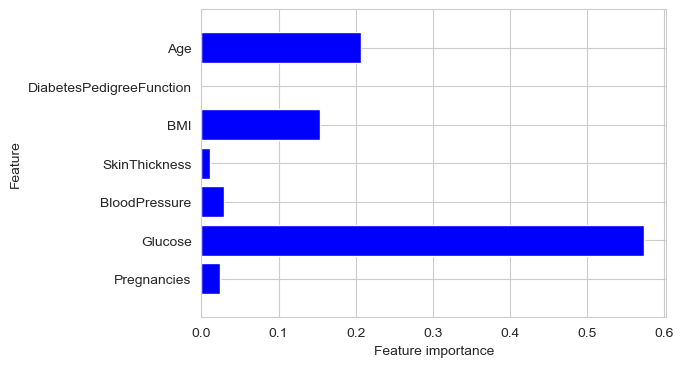

-------------------------------------------------------------------
Resultados do Modelo 2 - Todas as Colunas (Resample & Normalizado):

Acurácia do Treino: 96.73%
Acurácia do Teste: 92.17%

Matriz de Confusão:
[[46  5]
 [ 4 60]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        51
           1       0.92      0.94      0.93        64

    accuracy                           0.92       115
   macro avg       0.92      0.92      0.92       115
weighted avg       0.92      0.92      0.92       115



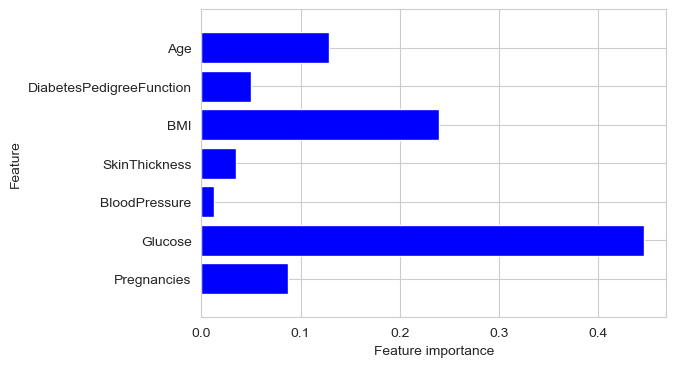

-------------------------------------------------------------------


In [48]:
#region Resultados do Modelo 2 - Todas as Colunas
# ---
params3 = {
    "criterion": "entropy",
    "max_depth": 7,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "splitter": "best",
    "random_state": 1,
}

# ---
params7 = {
    "criterion": "entropy",
    "max_depth": 10,
    "min_samples_leaf": 1,
    "min_samples_split": 3,
    "splitter": "random",
    "random_state": 21,
}

print("-------------------------------------------------------------------")
print("Resultados do Modelo 2 - Todas as Colunas (Resample):\n")
trainAndEvaluate(
    X_resampled1,
    y_resampled1,
    params=params3,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("-------------------------------------------------------------------")
print("Resultados do Modelo 2 - Todas as Colunas (Resample & Normalizado):\n")
trainAndEvaluate(
    X_resampled3,
    y_resampled3,
    params=params7,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("-------------------------------------------------------------------")
#endregion

#### Modelo 2 - Features - Resample / Resample & Normalizado

--------------------------------------------------------
Resultados do Modelo 2 - Features (Resample):

Acurácia do Treino: 100.00%
Acurácia do Teste: 97.17%

Matriz de Confusão:
[[50  1]
 [ 2 53]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        51
           1       0.98      0.96      0.97        55

    accuracy                           0.97       106
   macro avg       0.97      0.97      0.97       106
weighted avg       0.97      0.97      0.97       106



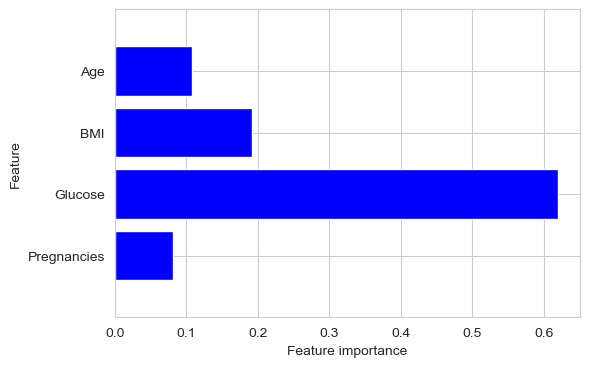

--------------------------------------------------------
Resultados do Modelo 2 - Features (Resample & Normalizado):

Acurácia do Treino: 96.18%
Acurácia do Teste: 96.43%

Matriz de Confusão:
[[50  2]
 [ 2 58]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.97      0.97      0.97        60

    accuracy                           0.96       112
   macro avg       0.96      0.96      0.96       112
weighted avg       0.96      0.96      0.96       112



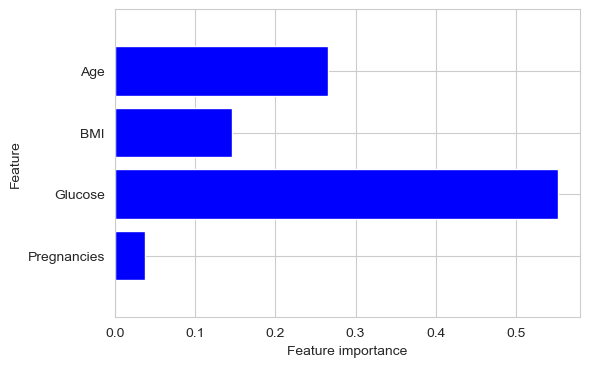

--------------------------------------------------------


In [49]:
#region Resultados do Modelo 2 - Features
params4 = {
    "criterion": "gini",
    "max_depth": 10,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "splitter": "best",
    "random_state": 1,
}

params8 = {
    "criterion": "entropy",
    "max_depth": 4,
    "min_samples_leaf": 2,
    "min_samples_split": 2,
    "splitter": "best",
    "random_state": 1,
}

print("--------------------------------------------------------")
print("Resultados do Modelo 2 - Features (Resample):\n")
trainAndEvaluate(
    X_resampled2,
    y_resampled2,
    params=params4,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("--------------------------------------------------------")
print("Resultados do Modelo 2 - Features (Resample & Normalizado):\n")
trainAndEvaluate(
    X_resampled4,
    y_resampled4,
    params=params8,
    state=SEED,
    showAccuracy=False,
    showConfusionMatrix=False,
    showClassificationReport=False,
    showFeatures=True,
    showTree=False,
)
print("--------------------------------------------------------")
#endregion

### Validação

In [50]:
#region Cross Validate
def testCrossValidate(X, y, params, seed=SEED):
    # ---
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.20,
        random_state=seed,
        shuffle=True,
        stratify=y,
    )

    # ---
    tree = DecisionTreeClassifier(**params)
    scores = cross_validate(
        tree,
        X_train,
        y_train,
        cv=5,
        scoring=["accuracy", "precision", "recall", "f1"],
        n_jobs=-1,
        verbose=0,
    )

    # ---
    print(f"Acurácia Média: {scores['test_accuracy'].mean():.2f}")
    print(f"Precisão Média: {scores['test_precision'].mean():.2f}")
    print(f"Recall Médio: {scores['test_recall'].mean():.2f}")
    print(f"F1-Score Médio: {scores['test_f1'].mean():.2f}")
#endregion

In [55]:
#region Impressão dos Resultados (Cross Validate)
print("-------------------------------------------------------------------")
print("Resultados do Modelo 0 - Todas as Colunas:\n")
testCrossValidate(X0, y0, params=params0)
print("-------------------------------------------------------------------")

print("-------------------------------------------------------------------")
print("Resultados do Modelo 1 - Features:\n")
testCrossValidate(X2, y2, params=params2)
print("-------------------------------------------------------------------")

print("-------------------------------------------------------------------")
print("Resultados do Modelo 2 - Features (Resample):\n")
testCrossValidate(X_resampled2, y_resampled2, params=params4)
print("-------------------------------------------------------------------")

print("-------------------------------------------------------------------")
print("Resultados do Modelo 2 - Features (Resample & Normalizado):\n")
testCrossValidate(X_resampled4, y_resampled4, params=params8)
print("-------------------------------------------------------------------")
#endregion

-------------------------------------------------------------------
Resultados do Modelo 0 - Todas as Colunas:

Acurácia Média: 0.70
Precisão Média: 0.56
Recall Médio: 0.60
F1-Score Médio: 0.58
-------------------------------------------------------------------
-------------------------------------------------------------------
Resultados do Modelo 1 - Features:

Acurácia Média: 0.78
Precisão Média: 0.68
Recall Médio: 0.68
F1-Score Médio: 0.68
-------------------------------------------------------------------
-------------------------------------------------------------------
Resultados do Modelo 2 - Features (Resample):

Acurácia Média: 0.94
Precisão Média: 0.92
Recall Médio: 0.97
F1-Score Médio: 0.94
-------------------------------------------------------------------
-------------------------------------------------------------------
Resultados do Modelo 2 - Features (Resample & Normalizado):

Acurácia Média: 0.93
Precisão Média: 0.94
Recall Médio: 0.94
F1-Score Médio: 0.94
--------

> Recall: deve-se considerar o maior *recall* em problemas onde é mais importante **minimizar os falsos negativos**.
> 
> Precisão: deve-se considerar a maior *precisão* em problemas onde cada positivo deve ser tratado com confiança. 

## Algoritmos Resample

In [52]:
#region Balancing Algorithms
def testBalancingAlgorithms(X, y, random_state=SEED):
    results = []

    algorithms = {
        "SMOTE": SMOTE(random_state=random_state),
        "ADASYN": ADASYN(random_state=random_state),
        "Borderline-SMOTE": BorderlineSMOTE(random_state=random_state),
        "SMOTETomek": SMOTETomek(random_state=random_state),
        "SMOTEENN": SMOTEENN(random_state=random_state),
        "TomekLinks": TomekLinks(),
        "Edited Nearest Neighbours (ENN)": EditedNearestNeighbours(),
    }

    for name, algorithm in algorithms.items():
        X_resampled, y_resampled = algorithm.fit_resample(X, y)

        train_X, test_X, train_y, test_y = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=random_state
        )

        model = DecisionTreeClassifier(random_state=random_state)
        model.fit(train_X, train_y)

        prediction = model.predict(test_X)
        accuracy = accuracy_score(test_y, prediction)

        results.append({"Algorithm": name, "Accuracy": accuracy * 100})

    return results


results = testBalancingAlgorithms(X2, y2)

print("\nResultados Finais:\n")
for result in results:
    print(f"{result['Algorithm']}: {result['Accuracy']:.2f}%")
#endregion


Resultados Finais:

SMOTE: 72.50%
ADASYN: 70.30%
Borderline-SMOTE: 69.00%
SMOTETomek: 73.12%
SMOTEENN: 90.57%
TomekLinks: 75.18%
Edited Nearest Neighbours (ENN): 85.32%


In [53]:
#region Comparação dos Dados / Antes & Pós Resample
# 0 -> sem diabetes
# 1 -> com diabetes
# sampling_strategy="not minority" -> 275 / 60

# -> 768
print(f"Distribuição das Classes SEM SMOTEENN:")
print(diabetes.groupby("Outcome").size())

# -> 557
print("\nDistribuição das Classes COM SMOTEENN:")
diabetesResampled = y_resampled4.to_frame(name="Outcome")
print(diabetesResampled.groupby("Outcome").size())
#endregion

Distribuição das Classes SEM SMOTEENN:
Outcome
0    500
1    268
dtype: int64

Distribuição das Classes COM SMOTEENN:
Outcome
0    260
1    297
dtype: int64


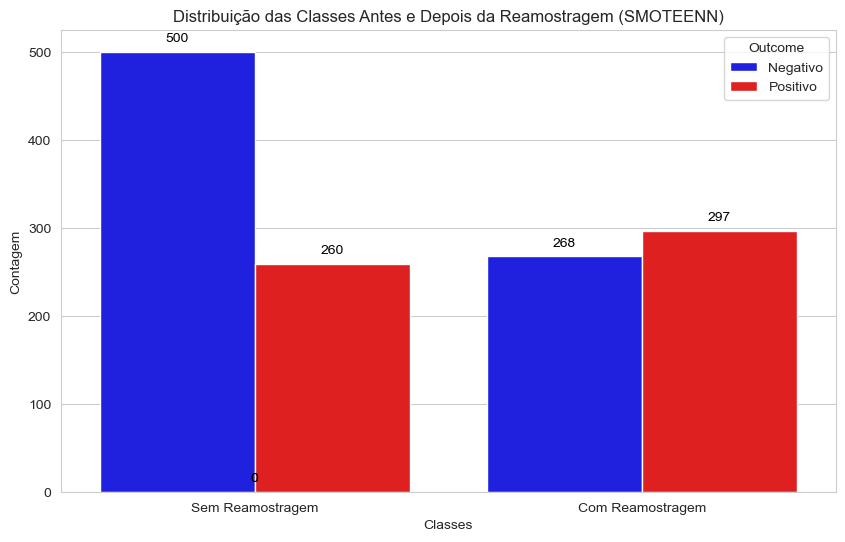

In [54]:
#region Comparação dos Dados / Antes & Pós Resample (Gráfico)
diabetes["Tipo"] = "Negativo"
diabetesResampled["Tipo"] = "Positivo"

dataConcat = pd.concat(
    [diabetes[["Outcome", "Tipo"]], diabetesResampled[["Outcome", "Tipo"]]]
)

plt.figure(figsize=(10, 6))
customPalette = ["blue", "red"]

ax = sns.countplot(x="Outcome", hue="Tipo", data=dataConcat, palette=customPalette)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.xticks([0, 1], ["Sem Reamostragem", "Com Reamostragem"])

plt.title("Distribuição das Classes Antes e Depois da Reamostragem (SMOTEENN)")
plt.xlabel("Classes")
plt.ylabel("Contagem")
plt.legend(title="Outcome")
plt.show()
#endregion